In [24]:
import numpy as np 
from numpy import array
import pandas as pd 
from sklearn import datasets
import statistics
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Setosa, Versicolour, and Virginica
# 0, 1 or 2
iris = datasets.load_iris()
# Sepal Length, Sepal Width, Petal Length and Petal Width
X = iris.data[:100, :]  # taking all 4 attributes within Setosa and Versicolour flower only
y = iris.target[ : 100] # taking only the Setosa and Versicolour flowers



In [82]:
# Make y shape == X shape
yReshaped = np.reshape(y, (np.size(y), 1))
# Append label to each featurevector
dataset = np.append(X, yReshaped, axis=1)
print("a dataset row: ", dataset[46])
# Find the labels e.g [1, 0]
classes = list(set(y))
classes.sort(reverse=True)
print("different classes:", classes)
# Separate the classes into positives and negatives
# Where 1 represent the positive class and vice versa
filterPositiveFeatureVectors = dataset[:, -1] == classes[0]
filterNegativeFeatureVectors = dataset[:, -1] == classes[1]
positiveFeatureVectors = dataset[filterPositiveFeatureVectors]
negativeFeatureVectors = dataset[filterNegativeFeatureVectors]
# Slicing away the labels
posFeatureMatrix = positiveFeatureVectors[:, : -1]
negFeatureMatrix = negativeFeatureVectors[:, : -1]
# Get the amount of different features e.g, 4
nrOfFeatures = np.size(X, axis=1)
# Transposing the matrix to sort the same kind of features in the same vector
# [f0:[1,5,9,13,17,19,21,23,25], f1:[2,6,10,14,18,20,22,24], ...]
posFeatureMatrixTransposed = np.transpose(posFeatureMatrix)
negFeatureMatrixTransposed = np.transpose(negFeatureMatrix)
# Calculating the normal distribution on all feature vectors
# Placing them in two separate distribution lists 
posDistrList = list(map(statistics.NormalDist.from_samples, posFeatureMatrixTransposed))
print(posDistrList)
negDistrList = list(map(statistics.NormalDist.from_samples, negFeatureMatrixTransposed))
print(negDistrList)



dataset row:  [5.1 3.8 1.6 0.2 0. ]
different classes: [1, 0]
[NormalDist(mu=5.936, sigma=0.5161711470638634), NormalDist(mu=2.77, sigma=0.3137983233784114), NormalDist(mu=4.26, sigma=0.46991097723995795), NormalDist(mu=1.3259999999999998, sigma=0.19775268000454405)]
[NormalDist(mu=5.006, sigma=0.3524896872134513), NormalDist(mu=3.428, sigma=0.37906436909628866), NormalDist(mu=1.462, sigma=0.17366399648018407), NormalDist(mu=0.24600000000000002, sigma=0.10538558938004566)]


In [83]:
newData = np.array([5.1, 3.8, 1.6, 0.2])
prior_pos = 0.5
prior_neg = 0.5
posterior_positive = prior_pos
for feature, distrObj in zip(newData, posDistrList):
    posterior_positive *= distrObj.pdf(feature)
    #print(feature, distrObj)
posterior_negative = prior_neg
for feature, distrObj in zip(newData, negDistrList):
    posterior_negative *= distrObj.pdf(feature)
    #print(feature, distrObj)

print("posterior positive: ", posterior_positive)
print("posterior negative: ", posterior_negative)

# Bayes theorem to calculate probabilty with the trained distributions. 
# Using pdf as refered to Probability density function from the normal distributions.
# As instructed in https://docs.python.org/3/library/statistics.html at the bottom.
# Skipping the evidence P(data) factor, because it is just a constant over all the factors which is redundant.

posterior positive:  1.0414487011162144e-17
posterior negative:  2.047381515735044


In [221]:

class MyNaiveBayesModel:
    """
    X = [[1 2 3 4],
        [5 6 7 8],
        [9 10 11 12],
        [13 14 15 16],
        [17 18 19 20]]

    y = [1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0]
    """
    def __init__(self):
        featureMatrixPositive = np.array()
        featureMatrixNegative = np.array()

       

    def fit(self, X, y):
        #e.g 4
        nrOfFeatures = np.size(X, axis=1)

        yReshaped = np.reshape(y, (np.size(y), 1))

        dataset = np.append(X, yReshaped, axis=1)

        print(dataset)


        #[f0:[1,5,9,13,17], f1:[2,6,10,14,18], ...]
        features_ordered = np.array_split(X, nrOfFeatures, axis=1)
        
        # Splitting positives and negatives and add them in each matrix
        

            # 1 value represent the positive class

            # 0 value represent the negative class

            
                 
        # Calculating the normal distribution on all feature buckets 
        self.sepl_pos_nDist = statistics.NormalDist.from_samples(self.sepl_pos)


    #newData = [1.3 4.2 3.3 6.1]
    def predict(self, newData):
        prior_pos = 0.5
        prior_neg = 0.5

        # Bayes theorem to calculate probabilty with the trained distributions. 
        # Using pdf as refered to Probability density function from the normal distributions.
        # As instructed in https://docs.python.org/3/library/statistics.html at the bottom.
        # Skipping the evidence P(data) factor, because it is just a constant over all the factors which is redundant.
        
        posterior_positive = (prior_pos * self.sepl_pos_nDist.pdf(newData[0]) * self.sepw_pos_nDist.pdf(newData[1]) * self.petl_pos_nDist.pdf(newData[2]) * self.petw_pos_nDist.pdf(newData[3]))  

        posterior_negative = (prior_neg * self.sepl_neg_nDist.pdf(flower[0]) * self.sepw_neg_nDist.pdf(flower[1]) * self.petl_neg_nDist.pdf(flower[2]) * self.petw_neg_nDist.pdf(flower[3]))  
            
        """
        if(posterior_positive > posterior_negative):
            return positive
        else:
            return negative 
        """
        # My design have a too low threshold for predicting. The likelihood ratio will always go through.
        # My algorithm is multiplying two likelihood greater than 1 sometimes, and it gives a even larger total likelihood ratio. 
        # However, it does not affect the classifying if the new data is either postive or negative. But the given probabiliteies for each class gets too far to 0 or 1.
        # Thus, my algorithm gives uncalibrated probability estimates, sadly. 
        # Theroetically this can be fixed by setting the weight ratio as a threshold for the likelihood ratio, but due to my bad python skills and time-planning I can not make it.
        return posterior_positive, posterior_negative


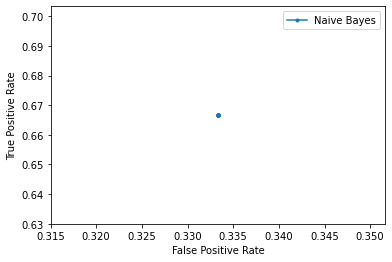

average accuracy:  1.0


In [222]:
# Cross validation 
k = 10
kf = KFold(n_splits=k, random_state=None, shuffle=True)
model = MyNaiveBayesModel()
accuracy_scores = []
fprs = []
tprs = []
mean_fprs = []
mean_tprs = []

for train_i, test_i in kf.split(X):
    X_train = X[train_i, :]
    y_train = y[train_i]
    X_test = X[test_i, : ]
    y_test = y[test_i]

    # Training the iris dataset, where normal distributions are calculated.
    model.fit( X_train, y_train)
    
    # Predicts if class is 1 = positive, or 0 = negative
    predictions = model.predict(X_test)

    # Predicts the probability that the class is positive
    probabilities = model.predict_pos_probability(X_test)

    # Calculates the accuracy
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy)

    # Calculates the fpr = false positive rate and tpr = true positive rate
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    fprs.append(fpr)
    tprs.append(tpr)

    # Calulating average fpr and tpr to create a average ROC
    mean_fprs.append(sum(fpr)/len(fpr))
    mean_tprs.append(sum(tpr)/len(tpr))
    
# Displaying the ROC curve
pyplot.plot(mean_fprs, mean_tprs, marker='.', label='Naive Bayes')
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()

# Displaying the average accuracy over the 10 folds
avg_accuracy_score = sum(accuracy_scores)/k
print("average accuracy: ", avg_accuracy_score)

